In [1]:
import pennylane as qml
from pennylane import numpy as np

In [2]:

num_qubits = 4 
dev = qml.device('default.qubit', wires=num_qubits)

In [3]:
"""
import matplotlib.pyplot as plt

# sample data
np.random.seed(3)  
data_x = np.random.rand(300, 2)   #features
data_y = np.random.randint(0, 2, 300)  #binary labels

# Plotting the data
plt.figure(figsize=(8, 6))
plt.scatter(data_x[data_y == 0][:, 0], data_x[data_y == 0][:, 1], color='red', label='Class 0')
plt.scatter(data_x[data_y == 1][:, 0], data_x[data_y == 1][:, 1], color='blue', label='Class 1')
plt.title('Sample Data Plot')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()
"""


"\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# sample data\nnp.random.seed(3)  \ndata_x = np.random.rand(300, 2)   #features\ndata_y = np.random.randint(0, 2, 300)  #binary labels\n\n# Plotting the data\nplt.figure(figsize=(8, 6))\nplt.scatter(data_x[data_y == 0][:, 0], data_x[data_y == 0][:, 1], color='red', label='Class 0')\nplt.scatter(data_x[data_y == 1][:, 0], data_x[data_y == 1][:, 1], color='blue', label='Class 1')\nplt.title('Sample Data Plot')\nplt.xlabel('Feature 1')\nplt.ylabel('Feature 2')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

In [4]:
def batch_data(data_x, data_y, batch_size):
    """
    Generator function to yield batches of data.
    
    Parameters:
    - data_x: NumPy array of input features, shape (total_samples, features)
    - data_y: NumPy array of labels, shape (total_samples,)
    - batch_size: integer, size of each batch
    
    Yields:
    - batch_x: NumPy array of features for the batch
    - batch_y: NumPy array of labels for the batch
    """
    total_samples = data_x.shape[0]
    indices = np.arange(total_samples)
    np.random.shuffle(indices)  # Shuffle the data
    
    for start_idx in range(0, total_samples, batch_size):
        end_idx = min(start_idx + batch_size, total_samples)
        batch_indices = indices[start_idx:end_idx]
        batch_x = data_x[batch_indices]
        batch_y = data_y[batch_indices]
        yield (batch_x, batch_y)

# Example usage:
# for batch_x, batch_y in batch_data(data_x, data_y, 10):
#     print(batch_x, batch_y)

In [5]:
def func_phi(w1,w2):
    return (w1-w2)**2

In [6]:
def ansatz(params):
    qml.RY(params[0],wires=[0])
    qml.RY(params[1],wires=[1])
    qml.CZ(wires=[0,1])

In [7]:
# Data Embedding for batch size = 4
def data_embedding_batch4(batch_x):
    for i in range(len(batch_x)):
        x = batch_x[i]
        phi = func_phi(x[0],x[1])
        qml.ctrl(qml.RY,control=[2,3],control_values=[1,1])(phi,[0])
        qml.ctrl(qml.RY,control=[2,3],control_values=[1,1])(phi,[1])
        if(i==0):
            qml.PauliX(wires=[3])
        elif(i==1):
            qml.PauliX(wires=[2])
            qml.PauliX(wires=[3])
        elif(i==2):
            qml.PauliX(3)
    # qml.Barrier(only_visual=True)
    qml.PauliX(wires=[2])
    qml.PauliX(wires=[3])
   
        


In [8]:
def adjoint_data_embedding_batch4(batch_x):
    qml.PauliX(wires=[2])
    qml.PauliX(wires=[3])
    last_index=len(batch_x)-1
    for i in range(len(batch_x)):
        x = batch_x[last_index-i]
        phi = func_phi(x[0],x[1])
        qml.ctrl(qml.adjoint(qml.RY),control=[2,3],control_values=[1,1])(phi,[1])
        qml.ctrl(qml.adjoint(qml.RY),control=[2,3],control_values=[1,1])(phi,[0])
        if(i==last_index-3):
            qml.PauliX(wires=[3])
        elif(i==last_index-2):
            qml.PauliX(wires=[2])
            qml.PauliX(wires=[3])
        elif(i==last_index-1):
            qml.PauliX(3)


In [9]:
def adjoint_ansatz(params):
        qml.CZ(wires=[0,1])
        qml.adjoint(qml.RY)(params[1],wires=[1])
        qml.adjoint(qml.RY)(params[0],wires=[0])
        

In [10]:
def buildGroverOracleAndDiffuserWithInverse(params,data):
    data_embedding_batch4(data)
    # qml.Barrier()
    ansatz(params)
    # qml.Barrier()
    qml.CCZ(wires=[0,2,3])
    # qml.Barrier()
    adjoint_ansatz(params)
    # qml.Barrier()
    adjoint_data_embedding_batch4(data)
    qml.templates.GroverOperator(wires=[2,3])

In [11]:
def buildGroverOracleDifusserNoInverse(params,data):
    data_embedding_batch4(data)
    # qml.Barrier(only_visual=True)
    ansatz(params)
    qml.CCZ(wires=[0,2,3])
    qml.templates.GroverOperator(wires=[2,3])

In [12]:
# batch_generator = homogeneous_batch_data(data_x, data_y, 4)
# batch_x, batch_y = next(batch_generator)

numberOfGroverIteration = 2

@qml.qnode(dev)
def qnn_grover_circuit(params, data):
    hadmadard_range = range(2,4)
    for i in hadmadard_range:
        qml.Hadamard(wires=i)
    for i in range(numberOfGroverIteration):
        qml.Barrier(only_visual=True)
        buildGroverOracleAndDiffuserWithInverse(params,data)
    qml.Barrier(only_visual=True)
    buildGroverOracleDifusserNoInverse(params,data)
    return qml.probs(wires=[0,1,2,3])
    # return qml.expval(qml.PauliZ(wires=3))

print(qml.draw(qnn_grover_circuit)([0.1,0.2],[[0.1,0.1],[0.2,0.2],[0.3,0.3],[0.4,0.4]]))

# print(qnn_grover_circuit([0.1,0.2],batch_x)[-1])





0: ─────||─╭RY(0.00)──────────────╭RY(0.00)──────────────╭RY(0.00)──────────────╭RY(0.00)──RY(0.10)
1: ─────||─│─────────╭RY(0.00)────│─────────╭RY(0.00)────│─────────╭RY(0.00)────│─────────╭RY(0.00)
2: ──H──||─├●────────├●───────────├●────────├●─────────X─├●────────├●───────────├●────────├●───────
3: ──H──||─╰●────────╰●─────────X─╰●────────╰●─────────X─╰●────────╰●─────────X─╰●────────╰●───────

────────────╭●─╭●─╭●──RY(0.10)†────────────╭RY(0.00)†───────────────╭RY(0.00)†──────────────
───RY(0.20)─╰Z─│──╰Z──RY(0.20)†─╭RY(0.00)†─│─────────────╭RY(0.00)†─│─────────────╭RY(0.00)†
───X───────────├●──X────────────├●─────────├●────────────├●─────────├●──────────X─├●────────
───X───────────╰Z──X────────────╰●─────────╰●──────────X─╰●─────────╰●──────────X─╰●────────

──╭RY(0.00)†───────────────╭RY(0.00)†──────────────────||─╭RY(0.00)──────────────╭RY(0.00)──────────
──│─────────────╭RY(0.00)†─│───────────────────────────||─│─────────╭RY(0.00)────│─────────╭RY(0.00)
──├●────────────├●──────

In [13]:
# def homogeneous_batch_data(data_x, data_y, batch_size):
#     """
#     Generator function to yield batches of data where all samples in a batch have the same label.
    
#     Parameters:
#     - data_x: NumPy array of input features, shape (total_samples, features)
#     - data_y: NumPy array of labels, shape (total_samples,)
#     - batch_size: integer, size of each batch
    
#     Yields:
#     - batch_x: NumPy array of features for the batch
#     - batch_y: NumPy array of labels for the batch
#     """
#     # Segregate data by labels
#     unique_labels = np.unique(data_y)
#     for label in unique_labels:
#         # Extract all samples with the current label
#         label_indices = np.where(data_y == label)[0]
#         np.random.shuffle(label_indices)  # Shuffle indices to randomize batch content
        
#         for start_idx in range(0, len(label_indices), batch_size):
#             end_idx = min(start_idx + batch_size, len(label_indices))
#             batch_indices = label_indices[start_idx:end_idx]
#             batch_x = data_x[batch_indices]
#             batch_y = data_y[batch_indices]
#             yield (batch_x, batch_y)

# Example usage:
# data_x, data_y are your datasets
# for batch_x, batch_y in homogeneous_batch_data(data_x, data_y, 4):
#     print("Batch X:", batch_x)
#     print("Batch Y:", batch_y)

# res = homogeneous_batch_data(data_x, data_y, 4)
# # batch_x, batch_y= homogeneous_batch_data(data_x, data_y, 4)
# batch_x, batch_y = next(res)
# print(batch_x)
# print(batch_y)
# for i in range(300):
#     batch_x, batch_y = next(res)
#     print(batch_x)
#     print(batch_y)

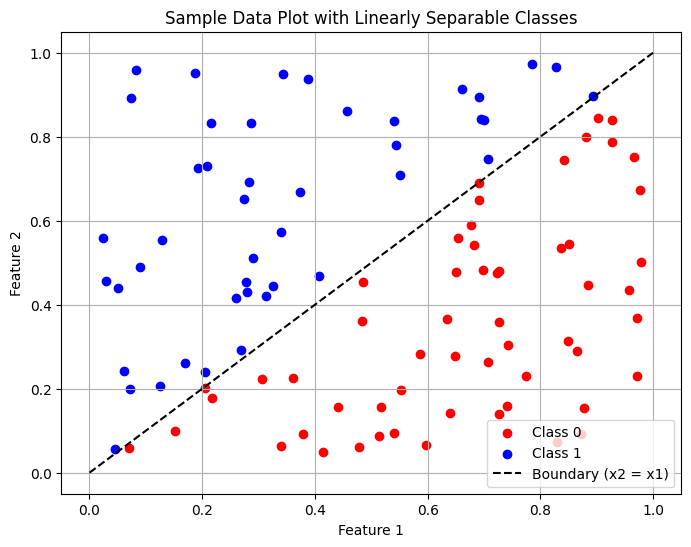

In [14]:

import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(3)

# Generate random features
data_x = np.random.rand(100, 2)  # 300 samples, 2 features

# Assign labels based on a linear separator
# Example: label 1 if feature2 > feature1 (i.e., above the line x2 = x1), else label 0
data_y = (data_x[:, 1] > data_x[:, 0]).astype(int)

# Plotting the data
plt.figure(figsize=(8, 6))
plt.scatter(data_x[data_y == 0][:, 0], data_x[data_y == 0][:, 1], color='red', label='Class 0')
plt.scatter(data_x[data_y == 1][:, 0], data_x[data_y == 1][:, 1], color='blue', label='Class 1')

# Draw the line x2 = x1 to show the boundary
plt.plot([0, 1], [0, 1], 'k--', label='Boundary (x2 = x1)')

plt.title('Sample Data Plot with Linearly Separable Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [15]:

def homogeneous_batch_data(data_x, data_y, batch_size):
    """
    Function to return two lists of batches of data where all samples in a batch have the same label.
    
    Parameters:
    - data_x: NumPy array of input features, shape (total_samples, features)
    - data_y: NumPy array of labels, shape (total_samples,)
    - batch_size: integer, size of each batch
    
    Returns:
    - batch_x_list: list of NumPy arrays of features for each batch
    - batch_y_list: list of NumPy arrays of labels for each batch
    """
    batch_x_list = []
    batch_y_list = []
    # Segregate data by labels
    unique_labels = np.unique(data_y)
    for label in unique_labels:
        # Extract all samples with the current label
        label_indices = np.where(data_y == label)[0]
        np.random.shuffle(label_indices)  # Shuffle indices to randomize batch content
        
        for start_idx in range(0, len(label_indices), batch_size):
            end_idx = min(start_idx + batch_size, len(label_indices))
            if(end_idx-start_idx!=batch_size):
                break
            batch_indices = label_indices[start_idx:end_idx]
            batch_x = data_x[batch_indices]
            batch_y = data_y[batch_indices]
            batch_x_list.append(batch_x)
            batch_y_list.append(batch_y)
    
    return batch_x_list, batch_y_list

# Example usage:
# Suppose data_x and data_y are already defined
# batch_x_list, batch_y_list = homogeneous_batch_data(data_x, data_y, 10)
# for batch_x, batch_y in zip(batch_x_list, batch_y_list):
#     print("Batch X:", batch_x)
#     print("Batch Y:", batch_y)

In [16]:

# optimizer = qml.GradientDescentOptimizer(stepsize=0.1)

# params = np.random.random([2])
# print(params)
# # throw Exception




# def cost(params, data, target):
#     label = target[0]
#     # print('==========')
#     # print(params)
#     # print(data)
#     # print(target)
#     # print('=========')
#     prob_last = qnn_grover_circuit(params, data)[-1]
#     # return ((prob_last - label)**2).mean()
#     return ((prob_last - label)**2).mean()


# new_cost = 0

# for it in range(100):  # The number of iterations of optimization
#     try:
#         data_x,target = next(batch_data_generator)
#         if(len(data_x)%4!=0):
#           print('finish training')
#           break 
#         params, new_cost = optimizer.step_and_cost(lambda v: cost(v, data_x, target), params)
#         print(params)
#         print(f'Iteration {it+1}: cost = {new_cost}')
#     except:
#         print('finish training - e')
#         break 
# print(new_cost)
# print(params)


In [17]:
def signFunction(threshold,x):
    if(x>threshold):
        return 1
    else:
        return 0

In [18]:
batch_x_list, batch_y_list= homogeneous_batch_data(data_x, data_y, 4)



optimizer = qml.AdamOptimizer()
np.random.seed(10)
params = np.random.random([2])


# def cost(params):
#     loss_t = []
#     for batch_x,batch_y in homogeneous_batch_data(data_x, data_y, 4):
#         label = batch_y[0]
#         prob_last = qnn_grover_circuit(params, batch_x)[-1]
#         # loss_batch= ((prob_last - label)**2).mean()
#         loss_batch = (prob_last - label)**2
#         loss_t+=loss_batch
#     return loss_t.mean()
#     return ((prob_last - label)**2).mean()
def cost(params):
    loss_t = []
    for batch_x, batch_y in zip(batch_x_list, batch_y_list):
        label = batch_y[0]
        # if(label==0):
        #      continue
        prob_last = qnn_grover_circuit(params, batch_x)[-1]
        # predict = signFunction(0.5,prob_last)
        predict = prob_last
        # print(prob_last)
        # print(predict)
        # print(label)
        loss_batch = (predict - label)**2
        loss_t.append(loss_batch) 
    # print(loss_t)
    loss_t = np.array(loss_t)
    return np.mean(loss_t)  



print(params)
# throw Exception
print(cost(params))

new_cost = 0

for it in range(1000):  
        # params, new_cost = optimizer.step_and_cost(lambda v: cost(v), params)
        params, new_cost = optimizer.step_and_cost(lambda v: cost(v), params)
        print(params)
        print(f'Iteration {it+1}: cost = {new_cost}')

print(new_cost)
print(params)

[0.77132064 0.02075195]


0.4398472136304147
[0.78131883 0.03075112]
Iteration 1: cost = 0.4398472136304147
[0.79132889 0.04074605]
Iteration 2: cost = 0.4398279609003222
[0.80135801 0.05074588]
Iteration 3: cost = 0.43980524792087144
[0.81141347 0.06076217]
Iteration 4: cost = 0.43977891786598833
[0.82150251 0.07080665]
Iteration 5: cost = 0.43974879368074815
[0.83163217 0.08089035]
Iteration 6: cost = 0.4397146792591745
[0.84180932 0.09102317]
Iteration 7: cost = 0.43967636066927723
[0.85204052 0.10121388]
Iteration 8: cost = 0.4396336072143374
[0.86233206 0.1114701 ]
Iteration 9: cost = 0.43958617228342234
[0.87268987 0.12179843]
Iteration 10: cost = 0.4395337940153617
[0.8831195  0.13220453]
Iteration 11: cost = 0.4394761958190588
[0.89362616 0.14269325]
Iteration 12: cost = 0.43941308679211283
[0.90421461 0.15326871]
Iteration 13: cost = 0.43934416207310156
[0.91488923 0.16393437]
Iteration 14: cost = 0.43926910315560064
[0.925654   0.17469313]
Iteration 15: cost = 0.4391875781857102
[0.93651247 0.18554739

In [19]:
# dev2 = qml.device('default.qubit', wires=2)
# @qml.qnode(dev2)
# def qnn_grover_predict_circuit(params, x):
#     phi = func_phi(x[0],x[1])
#     qml.RY(phi,wires=[0])
#     qml.RY(phi,wires=[1])
#     ansatz(params=params)
#     return qml.expval(qml.PauliZ(wires=0))

# print(qml.draw(qnn_grover_predict_circuit)(params,[0,1]))


In [20]:
# data_y_predict =[]
# for x in data_x:
#     predict = qnn_grover_predict_circuit(params,x)
#     data_y_predict.append(predict)

# for i in range(len(data_y)):
#     print('real y = ',data_y[i], 'predict y',data_y_predict[i])
